In [ ]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from google.colab import files
from scipy import linalg as lg 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
np.set_printoptions(threshold=False)
from itertools import chain

!unzip /content/archive  -d "/content/dataset"



Archive:  /content/archive.zip
replace /content/dataset/README? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
def import_dataset():

  path = "/content/dataset/"
  dirs = glob.glob(f'{path}*/')
  read_img = []
  for dir in tqdm(dirs):
      images = [np.array(Image.open(image)) for image in glob.glob(f'{dir}*')]
      read_img.append(images)
  new_list = []
  for i in read_img:
      for j in i:
          new_list.append(j)
  for i in range(400):
      new_list[i] = new_list[i].reshape(10304)
  m = np.array(new_list)
  df = pd.DataFrame(new_list)
  df['Label'] = 99
  x = 0
  for y in range(40):
      for i in range(x,x+10):
          df.iat[i,10304] = y+1
      x = x +10
  return df

In [ ]:
df  = import_dataset()

100%|██████████| 40/40 [00:00<00:00, 270.55it/s]


In [ ]:
labels = df["Label"].to_numpy()
def FiftyFiftySplit():
  testing = df.iloc[::2]
  training = df.iloc[1::2]
  return testing,training

In [ ]:
def SeventyThirtySplit():
  # Data Split for bonus 30/70
  tests = np.zeros((120,10305), dtype=np.int)
  trains = np.zeros((280,10305), dtype=np.int)
  x=0
  y=0
  for i in range(40):
    temp = df.loc[df['Label'] == i+1]
    temp = np.array(temp)
    tests[x:x+3,:] = temp[0:3,:]
    trains[y:y+7,:] = temp[3:10,:]
    x += 3
    y += 7
  tests = pd.DataFrame(tests).rename({10304: 'Label'}, axis='columns')
  trains = pd.DataFrame(trains).rename({10304: 'Label'}, axis='columns')
  return tests,trains

In [ ]:
def KNNClassifier(training_data,training_label,testing_data,testing_label,alpha):
    kneighbours = [1,3,5,7]
    accuracy = []

     #using 1,3,5,7 neighbours
    for i,neighbour in zip(range(len(kneighbours)),kneighbours):
        print("Using Neighbour Count = ",neighbour)

        #our KNN model (fitting & testing)
        clf = KNeighborsClassifier(n_neighbors = neighbour, weights = 'distance') 
        clf.fit(training_data.T, training_label) 
        predictions = clf.predict(testing_data.T)
        print(predictions)
        print(testing_label.values.flatten())

        #accuracy
        accuracy.append(accuracy_score(predictions,testing_label.values.flatten())) 
        if alpha != 0:
         print("Accuracy with alpha = ",alpha,"and K = ",neighbour," = ",accuracy[i])

        else:
         print("Accuracy K = ",neighbour," = ",accuracy[i])


        wrong = 0
        for i in range(0,len(predictions)):
          #print("Classified as: ", predictions[i], " Actual Label: ", testing_label.values.flatten()[i])
            if((predictions[i]) != (testing_label.values.flatten()[i])):
              wrong+=1
              
    print(accuracy)
    print("Wrong Predictions = " , wrong)
    print("***********************************")
    plt.plot(kneighbours,accuracy)
    plt.show()


alphaValues = [0.8,0.85,0.9,0.95]
components = 0

In [ ]:


def PCA(alphaValues,training,testing):

  training_labels = training['Label']
  testing_labels = testing['Label']
  print(training.shape)

  training = training.drop('Label',axis=1)
  testing = testing.drop('Label',axis=1)
  print(training.shape)

  #get normalized data
  mean = np.mean(training,axis = 0)
  training_data_normalized = training - mean
  testing_data_normalized = testing - np.mean(testing, axis = 0)


  #computing covariance matrix and eigenvalues and eigenvectors
  covariance_matrix = np.cov(training_data_normalized,rowvar = 0 , bias = 1)
  eigen_values , eigen_vectors = lg.eigh(covariance_matrix, turbo = True, check_finite = False)


  #sorting both in descending order
  idx = eigen_values.argsort()[::-1]
  eigen_values_sorted = eigen_values[idx]
  eigen_vectors_sorted = eigen_vectors[:,idx]


  for alpha in alphaValues:
     #getting number of components according to given explained variance
      for i in range(0,training.shape[1]):
          if(float(sum(eigen_values_sorted[:i]))/float(sum(eigen_values_sorted)) >= alpha): 
            components = i
            print("Using", components,"Principal Components \n")
            break
    
      #getting reduced vectors
      reduced_vectors = eigen_vectors_sorted[: , 0 : components + 1]

      #projecting new training and testing matrices
      new_train = np.dot(reduced_vectors.T , training_data_normalized.T)
      new_test = np.dot(reduced_vectors.T , testing_data_normalized.T)
      print("Alpha Value: " , alpha )
      print("***********************************")
      #testing
      KNNClassifier(new_train,training_labels,new_test,testing_labels,alpha)




In [ ]:
def LDA(training, testing, n_to_project, n_classes,pixels, n_samples):
  
 
  #overall mean
  m = np.array(training.drop('Label',axis=1).mean(axis = 0)).reshape(1,pixels)
 
 
  #calculating mean vector for every class
  M = np.zeros((n_classes,pixels))
  for i in range(n_classes):
    M[i,:] = np.array(training.loc[training['Label'] == i+1].drop('Label',axis=1).mean(axis = 0)).reshape(1,pixels)
 
 
  #Within Class Scatter Matrix
  Sw = np.zeros((pixels,pixels))
  Si = np.zeros((pixels,pixels))
  mi = np.zeros((1,pixels))
  for i in range(n_classes):
    mi = M[i,:].reshape(1,pixels)
    Di = np.array(training.loc[training['Label'] == i+1].drop('Label',axis=1))
    Z = Di - mi
    Si = np.dot(Z.T,Z)
    Sw = Sw + Si
  #print("Within Class Scatter Matrix:\n",Sw)
  
 
 
  #Between Class Scatter Matrix
  Sb = np.zeros((pixels,pixels))
  mi = np.zeros((1,pixels))
  Si = np.zeros((1,pixels))
  for i in range(n_classes):
    mi = M[i,:].reshape(1,pixels)
    mm = mi - m
    Si = np.dot(mm.T,mm)
    Si = Si*n_samples[i]
    Sb += Si
  if n_classes <=2:
    m1 = M[0,:].reshape(1,pixels)
    m2 = M[1,:].reshape(1,pixels)
    Z = m1 - m2
    Sb = np.dot(Z.T,Z)
  #print("Between Class Scatter Matrix:\n",Sb)
 
 
  #getting eigen values and vectors
  Sw_inverse = np.linalg.inv(Sw)
  math_symm = (np.triu_indices(len(Sw_inverse), 1))
  Sw_inverse[math_symm]=np.tril(Sw_inverse, -1).T[math_symm]
  temp_output = np.dot(Sw_inverse,Sb)
  eigenvalues, eigenvectors = lg.eigh(temp_output,
  b = np.eye(len(temp_output), dtype = temp_output.dtype), turbo = True, check_finite = False)

  #print(eigenvalues.shape)
  #print("\nEigen Values:\n",eigenvalues)
  #print(eigenvectors.shape)
  #print("\nEigen Vectors:\n", eigenvectors)
  
 
  #getting projected matrix
  columns_to_project = eigenvalues.argsort()[::-1]
  Eigenvaluessorted = eigenvalues[columns_to_project]
  Eigenvectorssorted = eigenvectors[:,columns_to_project]
  Projected_Matrix = Eigenvectorssorted[:,0:n_to_project]
 
 
  #Accuracy 
  tst =  np.array(testing.drop('Label',axis=1))
  trn = np.array(training.drop('Label',axis=1))
 
  new_trn = np.dot(Projected_Matrix.T , trn.T)
  new_tst = np.dot(Projected_Matrix.T , tst.T)
 
  training_labels = training['Label']
  testing_labels = testing['Label']
  
  KNNClassifier(new_trn,training_labels,new_tst,testing_labels,0)
 
## End of LDA ##

In [ ]:
Test_fifty, Train_fifty = FiftyFiftySplit()
Test_Thirty, Train_Seventy = SeventyThirtySplit()

FIFTY FIFTY SPLIT LDA 

Using Neighbour Count =  1
[ 1  1  1 ... 40 40 40]
[ 1  1  1 ... 40 40 40]
Accuracy K =  1  =  0.925
Using Neighbour Count =  3
[31  1  1 ... 40 40 40]
[ 1  1  1 ... 40 40 40]
Accuracy K =  3  =  0.905
Using Neighbour Count =  5
[31  1  1 ... 40 40 40]
[ 1  1  1 ... 40 40 40]
Accuracy K =  5  =  0.88
Using Neighbour Count =  7
[31  1  1 ... 40 40 40]
[ 1  1  1 ... 40 40 40]
Accuracy K =  7  =  0.855
Wrong Predictions =  29
***********************************


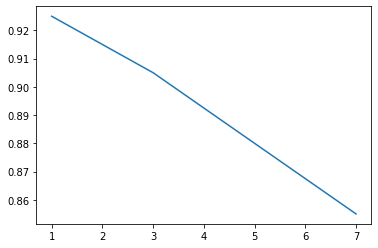

In [ ]:
print("FIFTY FIFTY SPLIT LDA \n")
Test_fifty, Train_fifty = FiftyFiftySplit()
LDA(Train_fifty, Test_fifty, 39, 40, 10304, [5,5,5,5,5,5,5,5,5,5]) #50/50 LDA

SEVENTY THIRTY SPLIT PCA 

(280, 10305)
(280, 10304)
Using 38 Principal Components 

Alpha Value:  0.8
***********************************
Using Neighbour Count =  1
[ 1  1  1 ... 40 40 40]
[ 1  1  1 ... 40 40 40]
Accuracy with alpha =  0.8 and K =  1  =  0.975
Using Neighbour Count =  3
[ 1  1  1 ... 40 40 40]
[ 1  1  1 ... 40 40 40]
Accuracy with alpha =  0.8 and K =  3  =  0.9666666666666667
Using Neighbour Count =  5
[ 1  1  1 ... 40 40 40]
[ 1  1  1 ... 40 40 40]
Accuracy with alpha =  0.8 and K =  5  =  0.95
Using Neighbour Count =  7
[ 1 40  1 ... 40 40 40]
[ 1  1  1 ... 40 40 40]
Accuracy with alpha =  0.8 and K =  7  =  0.9333333333333333
Wrong Predictions =  8
***********************************


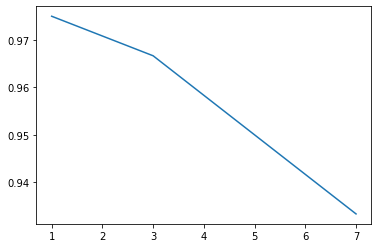

Using 57 Principal Components 

Alpha Value:  0.85
***********************************
Using Neighbour Count =  1
[ 1  1  1 ... 40 40 40]
[ 1  1  1 ... 40 40 40]
Accuracy with alpha =  0.85 and K =  1  =  0.9666666666666667
Using Neighbour Count =  3
[ 1  1  1 ... 40 40 40]
[ 1  1  1 ... 40 40 40]
Accuracy with alpha =  0.85 and K =  3  =  0.9583333333333334
Using Neighbour Count =  5
[ 1  1  1 ... 40 40 40]
[ 1  1  1 ... 40 40 40]
Accuracy with alpha =  0.85 and K =  5  =  0.9583333333333334
Using Neighbour Count =  7
[ 1 40  1 ... 40 40 40]
[ 1  1  1 ... 40 40 40]
Accuracy with alpha =  0.85 and K =  7  =  0.9333333333333333
Wrong Predictions =  8
***********************************


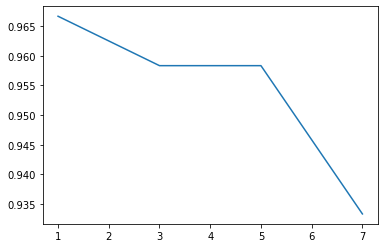

Using 88 Principal Components 

Alpha Value:  0.9
***********************************
Using Neighbour Count =  1
[ 1  1  1 ... 40 40 40]
[ 1  1  1 ... 40 40 40]
Accuracy with alpha =  0.9 and K =  1  =  0.9583333333333334
Using Neighbour Count =  3
[ 1  1  1 ... 40 40 40]
[ 1  1  1 ... 40 40 40]
Accuracy with alpha =  0.9 and K =  3  =  0.9416666666666667
Using Neighbour Count =  5
[14  1  1 ... 40 40 40]
[ 1  1  1 ... 40 40 40]
Accuracy with alpha =  0.9 and K =  5  =  0.9416666666666667
Using Neighbour Count =  7
[14 40  1 ... 40 40 40]
[ 1  1  1 ... 40 40 40]
Accuracy with alpha =  0.9 and K =  7  =  0.9083333333333333
Wrong Predictions =  11
***********************************


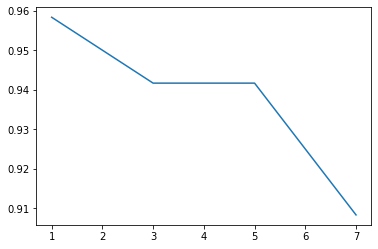

Using 144 Principal Components 

Alpha Value:  0.95
***********************************
Using Neighbour Count =  1
[ 1  1  1 ... 40 40 40]
[ 1  1  1 ... 40 40 40]
Accuracy with alpha =  0.95 and K =  1  =  0.9583333333333334
Using Neighbour Count =  3
[ 1  1  1 ... 40 40 40]
[ 1  1  1 ... 40 40 40]
Accuracy with alpha =  0.95 and K =  3  =  0.9333333333333333
Using Neighbour Count =  5
[14 40  1 ... 40 40 40]
[ 1  1  1 ... 40 40 40]
Accuracy with alpha =  0.95 and K =  5  =  0.9083333333333333
Using Neighbour Count =  7
[14 40  1 ... 40 40 40]
[ 1  1  1 ... 40 40 40]
Accuracy with alpha =  0.95 and K =  7  =  0.9083333333333333
Wrong Predictions =  11
***********************************


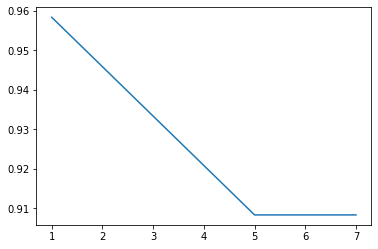

In [ ]:
## SEVENTY THIRTY PCA
print("SEVENTY THIRTY SPLIT PCA \n")
PCA(alphaValues,Train_Seventy,Test_Thirty)

SEVENTY THIRTY SPLIT LDA 

Using Neighbour Count =  1
[ 1  1  1 ... 40 40 40]
[ 1  1  1 ... 40 40 40]
Accuracy K =  1  =  0.9666666666666667
Using Neighbour Count =  3
[ 1  1  1 ... 40 40 40]
[ 1  1  1 ... 40 40 40]
Accuracy K =  3  =  0.9166666666666666
Using Neighbour Count =  5
[31  1  1 ... 40 40 40]
[ 1  1  1 ... 40 40 40]
Accuracy K =  5  =  0.9083333333333333
Using Neighbour Count =  7
[31  1  1 ... 40 40 40]
[ 1  1  1 ... 40 40 40]
Accuracy K =  7  =  0.9
[0.9666666666666667, 0.9166666666666666, 0.9083333333333333, 0.9]
Wrong Predictions =  12
***********************************


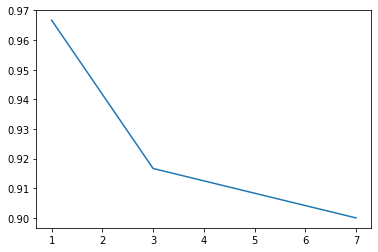

In [ ]:
## SEVENTY THIRTY LDA
print("SEVENTY THIRTY SPLIT LDA \n")
LDA(Train_Seventy, Test_Thirty, 39, 40, 10304, [7,7,7,7,7,7,7,7,7,7])

In [ ]:
import cv2
def load_dataset(path):

  data1 = []
  labels = []

  for i in range (1, 8):
    for pic in glob.glob(path +"s" + str(i) + "/"+"*.jpg"):
      img = cv2.imread(pic,cv2.IMREAD_GRAYSCALE)
      img=cv2.resize(img, (92,112), interpolation = cv2.INTER_AREA)
      img = np.array(img)
      vec = img.ravel()

      labels = np.append(labels, [i])
      data1 = np.append(data1, vec)
  data1 = np.array(data1).reshape((463, 10304))

  return data1,labels


!unzip /content/Data  -d "/content/datasets"

path = "/content/datasets/Data/"

def create_NonFaceDataset(no_of_non_faces):


  nonfaces_data,nonfaces_labels =  load_dataset(path)
  nonfaces_data=nonfaces_data[0:no_of_non_faces]
  nonfaces_labels=nonfaces_labels[0:no_of_non_faces]
  

  df_nonfaces_data = pd.DataFrame(nonfaces_data)
  df_nonfaces_data['Label'] = 2
  

  testing_nonfaces = df_nonfaces_data.iloc[::2]

  training_nonfaces = df_nonfaces_data.iloc[1::2]

  Train_fifty['Label'] = 1

  big_data_training = [Train_fifty, training_nonfaces]
  result = pd.concat(big_data_training)
  df_training = pd.DataFrame(result)

  Test_fifty['Label'] = 1

  big_data_testing = [Test_fifty, testing_nonfaces]
  result_t = pd.concat(big_data_testing)
  

  df_testing = pd.DataFrame(result_t)
  samples = np.array([200,no_of_non_faces/2])

  return df_training,df_testing,samples


Archive:  /content/Data.zip
replace /content/datasets/__MACOSX/._Data? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
df_training_400,df_testing_400,samples_400 = create_NonFaceDataset(400)
df_training_200,df_testing_200,samples_200 = create_NonFaceDataset(200)
df_training_100,df_testing_100,samples_100 = create_NonFaceDataset(100)
df_training_50,df_testing_50,samples_50 = create_NonFaceDataset(50)









/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


LDA WITH 400 FACE IMAGES AND 50 NON FACES 

Using Neighbour Count =  1
[1 1 1 ... 1 2 1]
[1 1 1 ... 2 2 2]
Accuracy K =  1  =  0.9244444444444444
Using Neighbour Count =  3
[1 1 1 ... 1 1 1]
[1 1 1 ... 2 2 2]
Accuracy K =  3  =  0.9155555555555556
Using Neighbour Count =  5
[1 1 1 ... 1 1 1]
[1 1 1 ... 2 2 2]
Accuracy K =  5  =  0.92
Using Neighbour Count =  7
[1 1 1 ... 1 1 1]
[1 1 1 ... 2 2 2]
Accuracy K =  7  =  0.92
Wrong Predictions =  18
***********************************


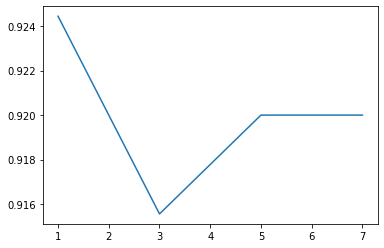

In [ ]:
print("LDA WITH 400 FACE IMAGES AND 50 NON FACES \n")
LDA(df_training_50, df_testing_50 , 1, 2, 10304, samples_50) #LDA WITH 50 NON FACES

LDA WITH 400 FACE IMAGES AND 100 NON FACES 

Using Neighbour Count =  1
[1 1 1 ... 2 2 2]
[1 1 1 ... 2 2 2]
Accuracy K =  1  =  0.896
Using Neighbour Count =  3
[1 1 1 ... 2 2 2]
[1 1 1 ... 2 2 2]
Accuracy K =  3  =  0.9
Using Neighbour Count =  5
[1 1 1 ... 2 2 2]
[1 1 1 ... 2 2 2]
Accuracy K =  5  =  0.9
Using Neighbour Count =  7
[1 1 1 ... 2 2 2]
[1 1 1 ... 2 2 2]
Accuracy K =  7  =  0.916
Wrong Predictions =  21
***********************************


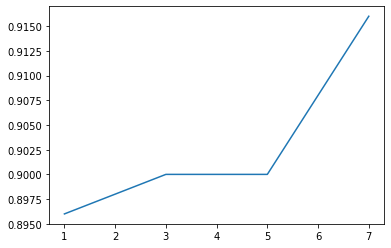

In [ ]:
print("LDA WITH 400 FACE IMAGES AND 100 NON FACES \n")
LDA(df_training_100, df_testing_100 , 1, 2, 10304, samples_100) #LDA WITH 100 NON FACES

LDA WITH 400 FACE IMAGES AND 200 NON FACES 

Using Neighbour Count =  1
[1 1 1 ... 2 1 2]
[1 1 1 ... 2 2 2]
Accuracy K =  1  =  0.8033333333333333
Using Neighbour Count =  3
[1 1 1 ... 2 1 2]
[1 1 1 ... 2 2 2]
Accuracy K =  3  =  0.8166666666666667
Using Neighbour Count =  5
[1 1 1 ... 2 1 2]
[1 1 1 ... 2 2 2]
Accuracy K =  5  =  0.8366666666666667
Using Neighbour Count =  7
[1 1 1 ... 2 1 2]
[1 1 1 ... 2 2 2]
Accuracy K =  7  =  0.84
Wrong Predictions =  48
***********************************


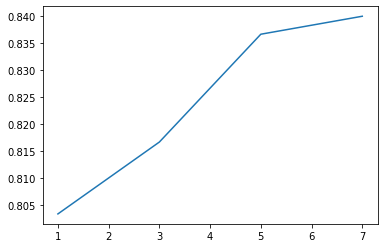

In [ ]:
print("LDA WITH 400 FACE IMAGES AND 200 NON FACES \n")
LDA(df_training_200, df_testing_200 , 1, 2, 10304, samples_200) #LDA WITH 200 NON FACES

LDA WITH 400 FACE IMAGES AND 400 NON FACES 

Using Neighbour Count =  1
[1 1 1 ... 2 1 2]
[1 1 1 ... 2 2 2]
Accuracy K =  1  =  0.7675
Using Neighbour Count =  3
[1 1 1 ... 2 1 2]
[1 1 1 ... 2 2 2]
Accuracy K =  3  =  0.7625
Using Neighbour Count =  5
[1 1 1 ... 2 1 2]
[1 1 1 ... 2 2 2]
Accuracy K =  5  =  0.7575
Using Neighbour Count =  7
[1 1 1 ... 2 1 2]
[1 1 1 ... 2 2 2]
Accuracy K =  7  =  0.7725
Wrong Predictions =  91
***********************************


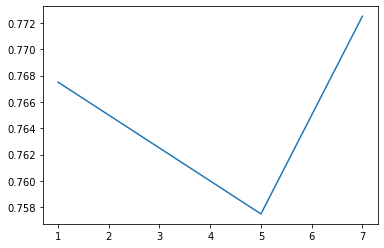

In [ ]:
print("LDA WITH 400 FACE IMAGES AND 400 NON FACES \n")
LDA(df_training_400, df_testing_400 , 1, 2, 10304, samples_400) #LDA WITH 400 NON FACES
